In [1]:
import pandas as pd

In [20]:
prices1= pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round4\round-4-island-data-bottle\prices_round_4_day_1.csv",sep =";")
prices2 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round5\Miquel\round-5-island-data-bottle\prices_round_5_day_2.csv", sep = ";")
prices3 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round5\Miquel\round-5-island-data-bottle\prices_round_5_day_3.csv", sep = ";")
prices4 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round5\Miquel\round-5-island-data-bottle\prices_round_5_day_4.csv", sep = ";")
trades2 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round5\Miquel\round-5-island-data-bottle\trades_round_5_day_2.csv",sep = ";")
trades3 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round5\Miquel\round-5-island-data-bottle\trades_round_5_day_3.csv",sep = ";")
trades4 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round5\Miquel\round-5-island-data-bottle\trades_round_5_day_4.csv",sep = ";")
observations1= pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round4\round-4-island-data-bottle\observations_round_4_day_1.csv")
observations2 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round5\Miquel\round-5-island-data-bottle\observations_round_5_day_2.csv")
observations3 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round5\Miquel\round-5-island-data-bottle\observations_round_5_day_3.csv")
observations4 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round5\Miquel\round-5-island-data-bottle\observations_round_5_day_4.csv")
prices1["day"] = 1
prices2["day"] = 2
prices3["day"] = 3
prices4["day"] = 4
prices = pd.concat([prices1,prices2,prices3,prices4],ignore_index=True)
prices.reset_index(inplace = True)
trades2["day"] = 2
trades3["day"] = 3
trades4["day"] = 4
trades = pd.concat([trades2,trades3,trades4],ignore_index=True)
trades.reset_index(inplace = True)
observations1["day"] = 1
observations2["day"] = 2
observations3["day"] = 3
observations4["day"] = 4
observations= pd.concat([observations1,observations2,observations3,observations4],ignore_index=True)
observations_2_4 = pd.concat([observations2,observations3,observations4])
observations.reset_index(inplace = True)
prices.loc[prices["day"] == 3, "timestamp"] += 1000000
prices.loc[prices["day"] == 4, "timestamp"] += 2000000
trades.loc[trades["day"] == 3, "timestamp"] += 1000000
trades.loc[trades["day"] == 4, "timestamp"] += 2000000
observations.loc[observations["day"] == 3, "timestamp"] += 1000000
observations.loc[observations["day"] == 4, "timestamp"] += 2000000
observations_2_4 = observations[observations["day"]>=2]

The Critical Sunlight Index (CSI) is: 56
When sunlight falls below this threshold, sugar and MACARON prices rise significantly
due to panic buying among residents.


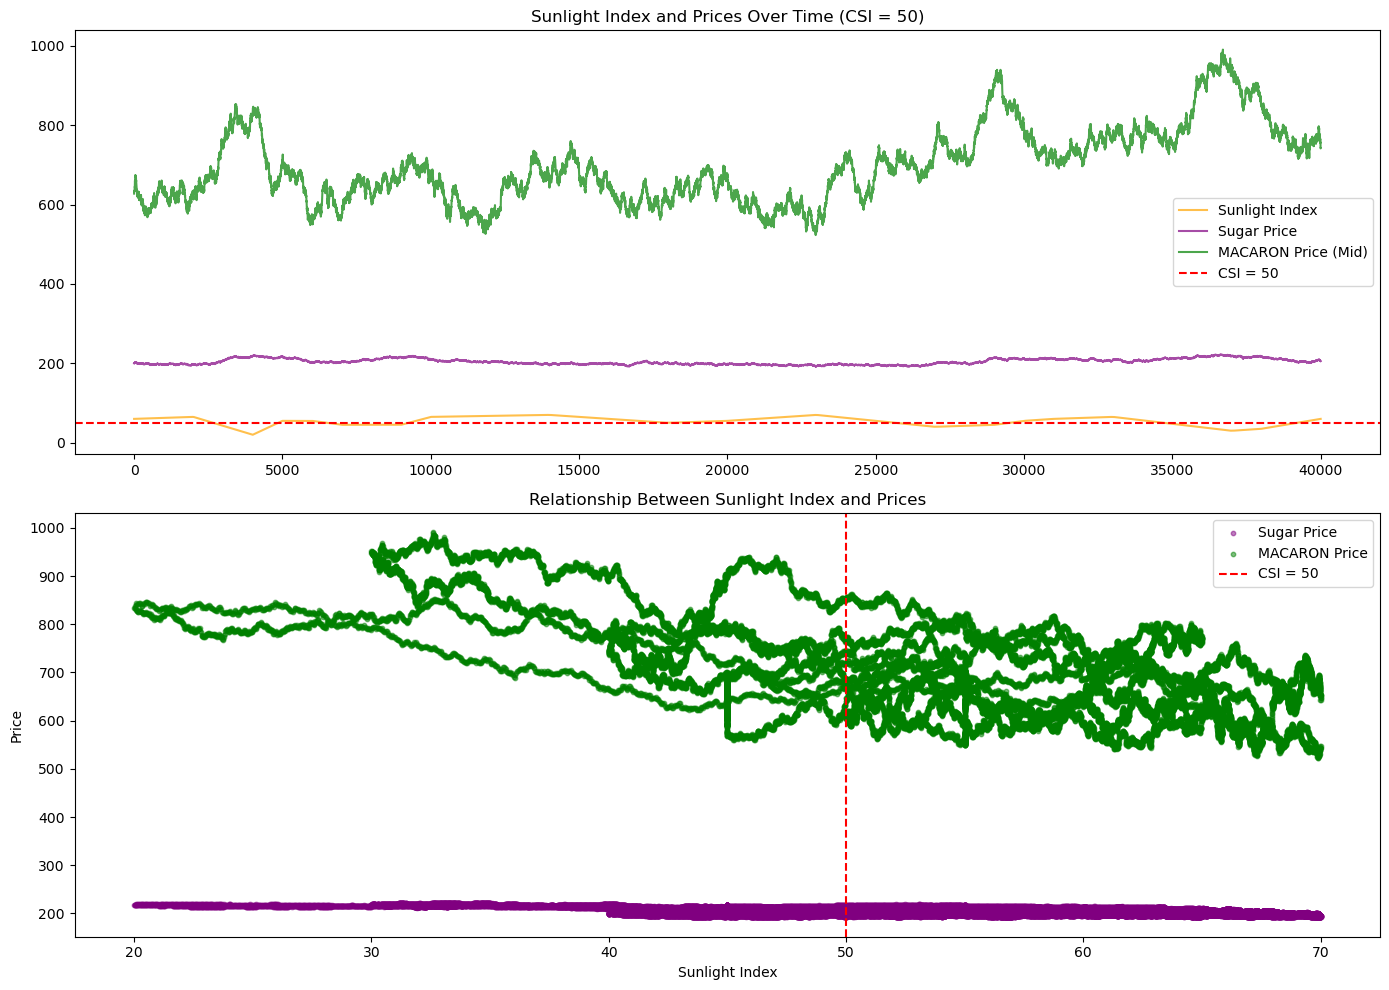


When sunlight is below CSI (56):
Sugar prices increase by: 2.77%
MACARON prices increase by: 11.59%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def analyze_csi(observations):
    # Calculate midPrice (MACARON price)
    observations['midPrice'] = (observations['bidPrice'] + observations['askPrice']) / 2
    results = []
    
    for threshold in range(20, 70):
        # Split data into points below and above threshold
        below_threshold = observations[observations['sunlightIndex'] < threshold]
        above_threshold = observations[observations['sunlightIndex'] >= threshold]
        
        # Skip if one group is too small
        if len(below_threshold) < 100 or len(above_threshold) < 100:
            continue
        
        # Calculate statistics for both groups
        below_stats = {
            'count': len(below_threshold),
            'avg_sugar': below_threshold['sugarPrice'].mean(),
            'avg_mid': below_threshold['midPrice'].mean(),
            'sugar_sunlight_corr': pearsonr(below_threshold['sunlightIndex'], below_threshold['sugarPrice'])[0],
            'mid_sunlight_corr': pearsonr(below_threshold['sunlightIndex'], below_threshold['midPrice'])[0]
        }
        
        above_stats = {
            'count': len(above_threshold),
            'avg_sugar': above_threshold['sugarPrice'].mean(),
            'avg_mid': above_threshold['midPrice'].mean(),
            'sugar_sunlight_corr': pearsonr(above_threshold['sunlightIndex'], above_threshold['sugarPrice'])[0],
            'mid_sunlight_corr': pearsonr(above_threshold['sunlightIndex'], above_threshold['midPrice'])[0]
        }
        
        # Calculate price ratios (below/above)
        price_ratios = {
            'sugar': below_stats['avg_sugar'] / above_stats['avg_sugar'],
            'mid': below_stats['avg_mid'] / above_stats['avg_mid']
        }
        
        # Calculate correlation difference (stronger negative correlation below CSI = better)
        corr_diff = {
            'sugar': abs(below_stats['sugar_sunlight_corr']) - abs(above_stats['sugar_sunlight_corr']),
            'mid': abs(below_stats['mid_sunlight_corr']) - abs(above_stats['mid_sunlight_corr'])
        }
        
        # Calculate balance factor (how evenly distributed the data is)
        total_count = len(observations)
        balance_factor = 1 - abs((below_stats['count'] / total_count) - 0.5) * 2  # 1 = perfect balance
        
        # Calculate score - higher is better
        # We want:
        # 1. Higher price ratio (prices increase more below threshold)
        # 2. Stronger correlation below threshold
        # 3. Balance between number of points above and below
        score = (price_ratios['sugar'] * 0.4) + (corr_diff['sugar'] * 0.4) + (balance_factor * 0.2)
        
        results.append({
            'threshold': threshold,
            'below_count': below_stats['count'],
            'above_count': above_stats['count'],
            'price_ratios': price_ratios,
            'corr_diff': corr_diff,
            'balance_factor': balance_factor,
            'score': score,
            'below_stats': below_stats,
            'above_stats': above_stats
        })
    
    # Sort by score descending
    results.sort(key=lambda x: x['score'], reverse=True)
    
    # Return the best threshold
    return results[0]['threshold']

def visualize_csi_impact(observations, csi):
    """
    Visualize the impact of CSI on prices
    
    Parameters:
    observations (DataFrame): DataFrame containing price and sunlight data
    csi (int): The identified Critical Sunlight Index
    """
    # Create a new figure
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Original price and sunlight data
    plt.subplot(2, 1, 1)
    plt.plot(observations['sunlightIndex'], label='Sunlight Index', color='orange', alpha=0.7)
    plt.plot(observations['sugarPrice'], label='Sugar Price', color='purple', alpha=0.7)
    plt.plot(observations['midPrice'], label='MACARON Price (Mid)', color='green', alpha=0.7)
    plt.axhline(y=csi, color='red', linestyle='--', label=f'CSI = {csi}')
    plt.legend()
    plt.title(f'Sunlight Index and Prices Over Time (CSI = {csi})')
    
    # Plot 2: Scatter plot of sunlight vs. prices with CSI marked
    plt.subplot(2, 1, 2)
    plt.scatter(observations['sunlightIndex'], observations['sugarPrice'], 
                label='Sugar Price', alpha=0.5, color='purple', s=10)
    plt.scatter(observations['sunlightIndex'], observations['midPrice'], 
                label='MACARON Price', alpha=0.5, color='green', s=10)
    plt.axvline(x=csi, color='red', linestyle='--', label=f'CSI = {csi}')
    plt.xlabel('Sunlight Index')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Relationship Between Sunlight Index and Prices')
    
    plt.tight_layout()
    plt.show()


csi = analyze_csi(observations)

print(f"The Critical Sunlight Index (CSI) is: {csi}")
print("When sunlight falls below this threshold, sugar and MACARON prices rise significantly")
print("due to panic buying among residents.")

# Visualize the impact of CSI
visualize_csi_impact(observations, 50)

# Additional analysis: Calculate average price increase when below CSI
below_csi = observations[observations['sunlightIndex'] < csi]
above_csi = observations[observations['sunlightIndex'] >= csi]

sugar_increase = below_csi['sugarPrice'].mean() / above_csi['sugarPrice'].mean()
macaron_increase = below_csi['midPrice'].mean() / above_csi['midPrice'].mean()

print(f"\nWhen sunlight is below CSI ({csi}):") 
print(f"Sugar prices increase by: {(sugar_increase-1)*100:.2f}%")
print(f"MACARON prices increase by: {(macaron_increase-1)*100:.2f}%")


In [42]:
observations_goodsun= observations_2_4[observations_2_4["sunlightIndex"]>=56]

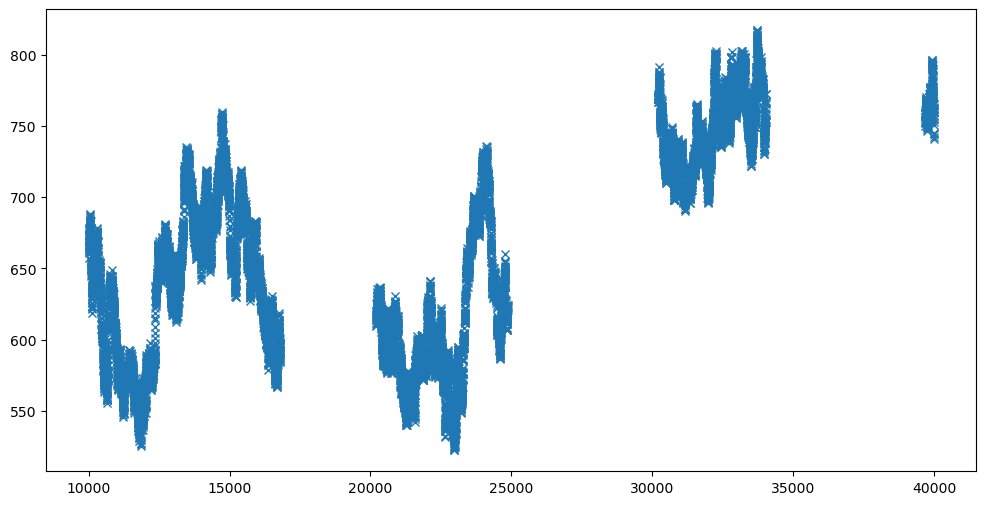

In [51]:
plt.figure(figsize=(12,6))
plt.plot(observations_goodsun["bidPrice"],"x")

In [52]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def calculate_ema(prices, span):
    return prices.ewm(span=span, adjust=False).mean()

df = observations_goodsun.copy()
df['mid_price']   = (df.askPrice + df.bidPrice) / 2
df['ema_short']   = calculate_ema(df['mid_price'], span=50)
df['ema_medium']  = calculate_ema(df['mid_price'], span=200)
df = df.fillna(method='bfill')

# build X, y
features = ['sunlightIndex','sugarPrice','exportTariff','importTariff','ema_short','ema_medium']
X = df[features].values
y = df['mid_price'].values

model = LinearRegression().fit(X, y)
coefs     = model.coef_    # shape (6,)
intercept = model.intercept_
print("R²:", model.score(X,y))


R²: 0.9860344880401816


C:\Users\Usuario1\AppData\Local\Temp\ipykernel_1512\2567722500.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


C:\Users\Usuario1\AppData\Local\Temp\ipykernel_1512\2720948194.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)   # backfill any leading NaNs


Coefficients: {'sunlightIndex': -0.05050388716074098, 'sugarPrice': 0.1204398602081983, 'exportTariff': -1.6131075206015915, 'importTariff': -0.7898835847384754, 'ema_short': 1.3333067132356633, 'ema_medium': -0.3697267929079656}
Intercept: 15.57885144091017
R‑squared: 0.9860344880401816


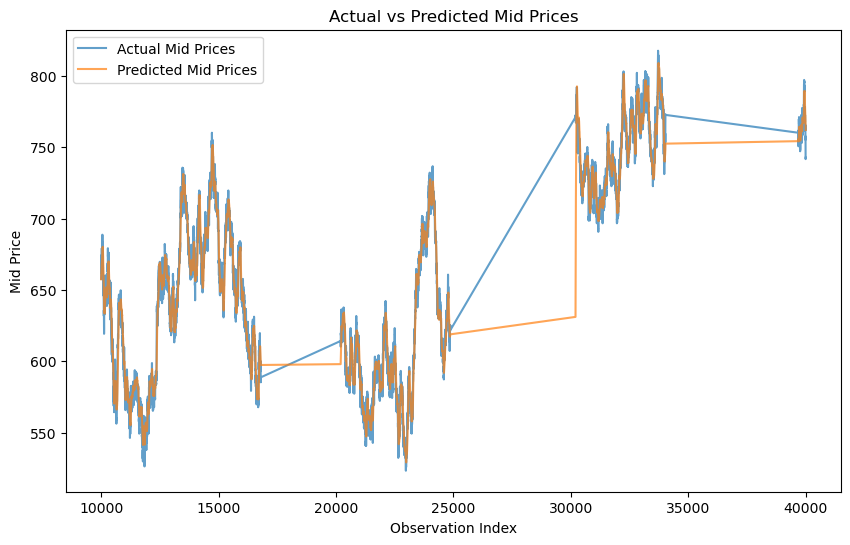

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def calculate_ema(prices, span):
    """Calculate exponential moving average."""
    return prices.ewm(span=span, adjust=False).mean()

# 1) Prepare your DataFrame
df = observations_goodsun.copy()
df['mid_price']   = (df['askPrice'] + df['bidPrice']) / 2
df['ema_short']   = calculate_ema(df['mid_price'], span=50)
df['ema_medium']  = calculate_ema(df['mid_price'], span=200)
df.fillna(method='bfill', inplace=True)   # backfill any leading NaNs

# 2) Build feature matrix X and target y
features = [
    'sunlightIndex',
    'sugarPrice',
    'exportTariff',
    'importTariff',
    'ema_short',
    'ema_medium'
]
X = df[features].values
y = df['mid_price'].values

# 3) Fit linear model
model = LinearRegression().fit(X, y)
print("Coefficients:", dict(zip(features, model.coef_)))
print("Intercept:", model.intercept_)
print("R‑squared:", model.score(X, y))

# 4) Make predictions
predicted_mids = model.predict(X)

# 5) Plot Actual vs Predicted on the same index
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['mid_price'],    label='Actual Mid Prices',    alpha=0.7)
plt.plot(df.index, predicted_mids,      label='Predicted Mid Prices',  alpha=0.7)
plt.title("Actual vs Predicted Mid Prices")
plt.xlabel("Observation Index")
plt.ylabel("Mid Price")
plt.legend()
plt.show()


In [54]:
model.coef_

array([-0.05050389,  0.12043986, -1.61310752, -0.78988358,  1.33330671,
       -0.36972679])

C:\Users\Usuario1\AppData\Local\Temp\ipykernel_1512\3007534781.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training = training.fillna(method='bfill')


Coefficients: [-0.05050389  0.12043986 -1.61310752 -0.78988358  1.33330671 -0.36972679]
Intercept: 15.578851440912558
R-squared: 0.9860344880401816


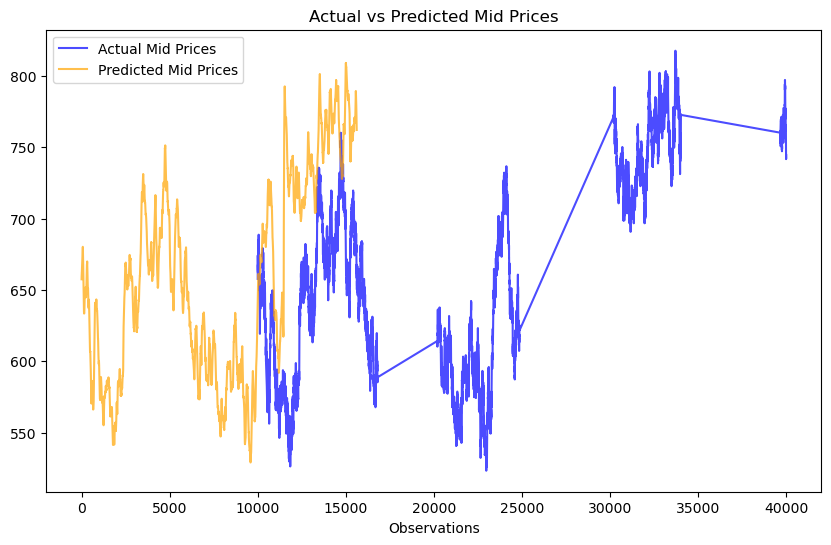

In [44]:
# First, calculate the exponential moving average
def calculate_ema(prices, span=100):
    """Calculate exponential moving average"""
    return prices.ewm(span=span, adjust=False).mean()

# Add EMA features to your training data
training = observations_goodsun.copy()

# Calculate mid price correctly (average of bid and ask)
training['mid_price'] = (training["askPrice"] + training["bidPrice"]) / 2

# Calculate EMAs of different lengths
training['ema_short'] = calculate_ema(training['mid_price'], span=50)
training['ema_medium'] = calculate_ema(training['mid_price'], span=200)

# Fill any NaN values that might appear at the start
training = training.fillna(method='bfill')

# Create feature matrix including EMAs
y = training['mid_price'].values
x = np.column_stack([
    training["sunlightIndex"].values, 
    training["sugarPrice"].values, 
    training["exportTariff"],
    training["importTariff"],
    training["ema_short"],
    training["ema_medium"],
    # You can also add EMA differences as a momentum indicator
])

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R-squared:", model.score(x, y))

# Predicting mid prices based on all features
predicted_mids = model.predict(x)

# Plotting the predicted mids against the actual mids
plt.figure(figsize=(10, 6))
plt.plot(training['mid_price'], label="Actual Mid Prices", color='blue', alpha=0.7)
plt.plot(predicted_mids, label="Predicted Mid Prices", color='orange', alpha=0.7)
plt.title("Actual vs Predicted Mid Prices")
plt.xlabel("Observations")
plt.legend()
plt.show()

In [ ]:
timestamps_goodsun = observations_goodsun["timestamp"].values

In [33]:
filtered_sun = trades[(trades["timestamp"].isin(timestamps_goodsun))& (trades["symbol"]=="MAGNIFICENT_MACARONS")]

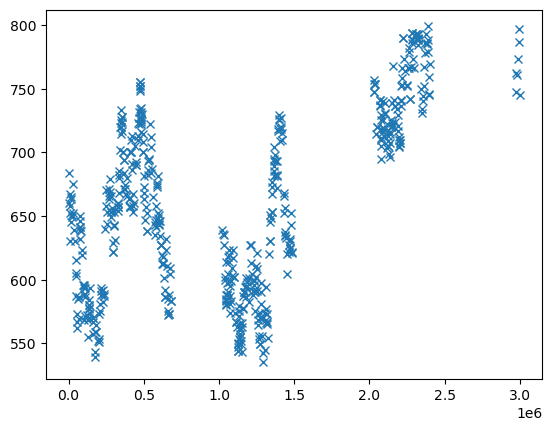

In [34]:
plt.plot(filtered_sun["timestamp"],filtered_sun["price"],"x")

In [36]:
filtered_sun_caesar_bids = filtered_sun[filtered_sun["buyer"]=="Caesar"]
filtered_sun_caesar_asks= filtered_sun[filtered_sun["seller"]=="Caesar"]

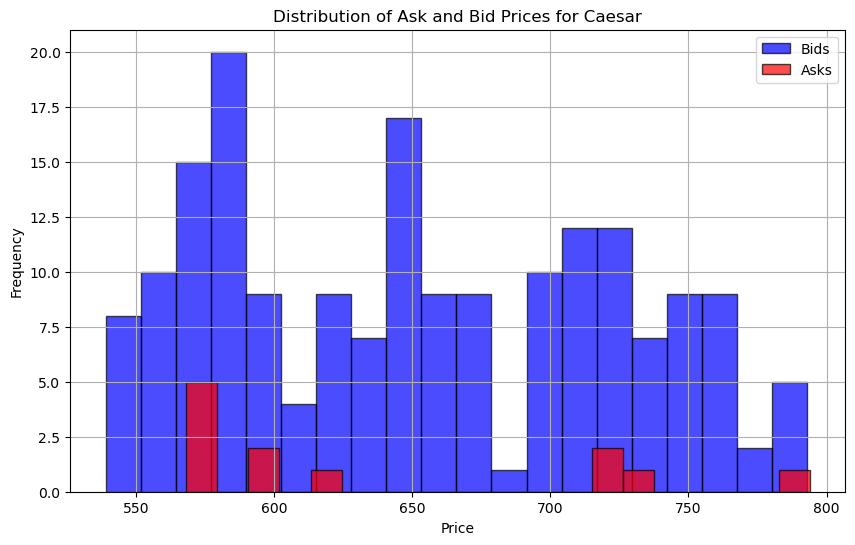

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(filtered_sun_caesar_bids["price"], bins=20, alpha=0.7, label="Bids", color="blue", edgecolor="black")
ax.hist(filtered_sun_caesar_asks["price"], bins=20, alpha=0.7, label="Asks", color="red", edgecolor="black")
ax.set_title("Distribution of Ask and Bid Prices for Caesar")
ax.set_xlabel("Price")
ax.set_ylabel("Frequency")
ax.grid(True)
ax.legend()
plt.show()